In [218]:
import numpy as np
def jump(x, alpha=0, beta=0.5):
    one = lambda x: 1
    return np.where((x<beta) & (x>=alpha), one(x), 0.)
def analytic(x,alpha2 = 0, beta2 = 1):
    two = lambda x: (alpha2*x + beta2)
    return two(x)

In [219]:
def picard_method(X, nx, nt, Tfinal, mu, theta):
    """theta picard method"""
    ### Parameters ###
    dx = (1-0)/(nx-1) 
    dt = (Tfinal-0)/(nt-1)
    C = 1*dt/(2*dx)
    D = mu*dt/(dx**2)
    
    ### warning ###
    if theta > 0:
        print("Warning, solving approximation to burgers")
    ### Initialise structure ###
    beta = np.zeros([nx])
    A = np.zeros([nx,nx])

    if theta >0:
        for i in range(0,nt-1):###time stepping###
        
            for j in range(0,nx): ### create vector on RHS###
                beta[j] = X[j]\
                - C*(1-theta)*X[j]*(X[(j+1)%nx] - X[(j-1)%nx])\
                + (D)*(1-theta)*(X[(j-1)%nx]-2*X[j]+X[(j+1)%nx])
        
            for p in range(0,nx): ### Create Matrix on LHS ###
                A[p,(p+1)%nx] =  theta*C*X[p] - theta*D # b 
                A[p,(p-1)%nx] = -theta*C*X[p] - theta*D  #c  
                A[p,p] = 1 + 2*theta*D
        
            X[:] = scipy.linalg.solve(A, beta)### Solving for next timestep ###
    if theta == 0: ## to avoid inverting a identity matrix pointlessly.
        for i in range(0,nt-1):###time stepping###
            for j in range(0,nx): ### create vector on RHS###
                beta[j] = X[j]\
                - C*(1-theta)*X[j]*(X[(j+1)%nx] - X[(j-1)%nx])\
                + (D)*(1-theta)*(X[(j-1)%nx]-2*X[j]+X[(j+1)%nx])

            X[:] = beta ### Solving for next timestep ###
    return X

In [220]:
def conservative_ftcs_method(X, nx, nt, Tfinal, mu):

    ## Parameters
    dx = (1-0)/(nx-1) 
    dt = (Tfinal-0)/(nt-1)
    C = 1*dt/(2*dx)
    D = mu*dt/(dx**2)
    a_1 = dx**2/(2*mu)
    a_2 = 2*mu/(1**2)
    
    
### needs stability criterion ###
### I am yet to do any but lax wendroff only useful for explicit case###
### when theta = 0 ###
    beta = np.zeros([nx])
    A = np.zeros([nx,nx])
    for i in range(0,nt-1):
        
        for j in range(0,nx): 
            beta[j] = X[j]\
            - C*0.5*(1)*(X[(j+1)%nx]**2 - X[(j-1)%nx]**2)\
            + (D)*(1)*(X[(j-1)%nx]-2*X[j]+X[(j+1)%nx])
    
        X[:] = beta
    return X

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from numpy.linalg import inv
import scipy.sparse

def newton_method(X, nx, nt, Tfinal, mu, theta):

    ### derived parameters ###
    dx = (1-0)/(nx-1) 
    dt = (Tfinal-0)/(nt-1)
    C = 1*dt/(2*dx)
    D = mu*dt/(dx**2)
    
    ##Creation of newton method structure 
    beta = np.zeros([nx])
    w = np.zeros([nx])
    dw = np.zeros([nx])

    for i in range(0,nt-1):### time loop 
        
        for j in range(0,nx): 
            w[j] = X[j] ### first initialise w^0 = phi^n as initial guess###
                          ### this is the starting guess for newton method ###
        
        ### Construct the newton loop
        tol = 10**(-13)## extreeme accuracy can be imposed
        err  = 2*tol
        while (err>tol): ### until convergence ###
            
            ### Create beta^k_j ###
            for q in range(0,nx): 
                beta[q] = X[q] - C*(1-theta)*X[q]*(X[(q+1)%nx] - X[(q-1)%nx]) + (D)*(1-theta)*(X[(q-1)%nx]-2*X[q]+X[(q+1)%nx]) \
                -w[q] - C*theta*w[q]*(w[(q+1)%nx]-w[(q-1)%nx]) + D*theta*(w[(q+1)%nx]-2*w[q] +w[(q-1)%nx])
            
            ##Create A^k_j ###
            A = np.zeros([nx,nx])
            for p in range(1,nx):
                A[p-1,p] = ((theta*C*w[p])-(theta*D)) # b
            for p in range(0,nx-1):
                A[p+1,p] = ((-theta*C*w[p+1])-(theta*D)) # c
            for p in range(0,nx):
                A[p,p] = (1+ 2*theta*D + C*theta*(w[(p+1)%nx]-w[(p-1)%nx]))
            
            
            ## solving for dw
            dw = scipy.linalg.solve(A, beta)
            err = np.linalg.norm(dw,2)
            ## improve the newton loop
            w = w + dw 
            ## we have w^k
            
    
        
        for j in range(0,nx): ##replace
            X[j] = w[j]


    return X 
    



In [222]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from numpy.linalg import inv
import scipy.sparse

def conservative_newton_method(X, nx, nt, Tfinal, mu, theta):
    ##derived constants
    dx = (1-0)/(nx-1) ##
    dt = (Tfinal-0)/(nt-1)
    ## Parameters
    C = 1*dt/(2*dx)
    D = mu*dt/(dx**2)
    ##

    ##Construction of the vector per timestep ie beta note for inversion we only want the 
    beta = np.zeros([nx])
    w = np.zeros([nx])
    dw = np.zeros([nx])

    for i in range(0,nt-1):### time loop 
        ## first initialise w^0 = phi^n
        for j in range(0,nx): 
            w[j] = X[j]

        ### Construct the newton loop
        tol = 10**(-13) ### accuracy can be imposed ###
        err  = 2*tol
        while (err>tol): ## eventually replace with while loop and stopping criterion

            ### Create beta^k ###
            for q in range(0,nx): 
                beta[q] = X[q] - C*0.5*(1-theta)*(X[(q+1)%nx]**2 - X[(q-1)%nx]**2) \
                + (D)*(1-theta)*(X[(q-1)%nx]-2*X[q]+X[(q+1)%nx]) \
                -w[q] - C*0.5*theta*(w[(q+1)%nx]**2-w[(q-1)%nx]**2) \
                + D*theta*(w[(q+1)%nx]-2*w[q] +w[(q-1)%nx])
            
            ### Create A^k_j, tridiag ###
            A = np.zeros([nx,nx])
            for p in range(1,nx):
                A[p-1,p] = ((theta*C*w[(p+1)%nx])-(theta*D)) # down zero across 1 = b
            for p in range(0,nx-1):
                A[p+1,p] = ((-theta*C*w[(p-1)%nx])-(theta*D)) # down 1 acros 0 = c
            for p in range(0,nx):
                A[p,p] = (1+ 2*theta*D + C*theta*(w[(p+1)%nx]-w[(p-1)%nx]))
        
            ## solving for dw
            dw = scipy.linalg.solve(A, beta)
            err = np.linalg.norm(dw,2)
            ## improve the newton loop
            w = w + dw 
            ## we have w^k
            
        
        for j in range(0,nx):
            X[j] = w[j]

    return X 
    



In [223]:
import numpy as np
import math as math
import matplotlib.pyplot as plt


def SolveBurger(nx ,nt ,Tfinal ,mu, method, theta, initial_condition = "jump" ):
    """SOLVES BURGERS EQUATION: u_t + u(u_x) - mu u_{xx} = 0 NUMERICALLY
                                u_t + (u^2/2)_x - mu u_{xx} = 0 Conservative form
       nx = number of space points
       nt = number of time points 
       Tfinal = the final time  
       mu = the viscosity in the burgers equation 
       
       method = input:=  "picard" SOLVES APPROXIMATION TO BURGERS EQUATION
                         "newton" SOLVES EXACT BURGERS EQUATION
                         "conservative_ftcs" SOLVES CONSERVATIVE FORM USING EXPLICIT METHOD
                         "conservatice_newton" SOLVES CONSERVATIVE FORM USING NEWTONS METHOD
       theta = 1 is implicit,
               0 is explicit """
    ##derived constants
    x = np.linspace(0,1,nx)
    dx = (1-0)/(nx-1) ##
    t = np.linspace(0,Tfinal,nt)
    dt = (Tfinal-0)/(nt-1)
    c = 1*(dt/dx)
    d = mu*(dt*1/(dx**2))
    
    ##**Creating the structure**## 
    X = np.zeros( [nx] )##**Each row contains a timestep**##
    
    ### Initialisation of BC ###
    if initial_condition == "jump":
        X[:] = jump(x, 0.1, 0.3)
    if initial_condition == "analytic":
        X[:] = analytic(x, 0.1, 0.3)
    
    plt.plot(x,X,'r',label='Initial Conditions')
### Timestepping the whole scheme 
    if method == "newton":
        newton_method(X, nx, nt, Tfinal, mu, theta)
    if method == "picard":
        picard_method(X, nx, nt, Tfinal, mu, theta)
    if method == "conservative_ftcs":
        conservative_ftcs_method(X, nx, nt, Tfinal, mu)
    if method == "conservative_newton":
        conservative_newton_method(X, nx, nt, Tfinal, mu, theta)
 
    return X

def PlottingIC(X,nx):
    x = np.linspace(0,1,nx)
    plt.plot(x,X,'r',label='Initial Conditions')

def Plotting(X,nx):
    x = np.linspace(0,1,nx)
### plotting final timestep ###
    y = X[:]
    plt.plot(x, y,'g',linewidth=0.5)
### not exactly user friendly ###

In [224]:
# analytical solution ## incomplete
### Do I need to compute against a analytical solution?
help(SolveBurger)

Help on function SolveBurger in module __main__:

SolveBurger(nx, nt, Tfinal, mu, method, theta, initial_condition='jump')
    SOLVES BURGERS EQUATION: u_t + u(u_x) - mu u_{xx} = 0 NUMERICALLY
                             u_t + (u^2/2)_x - mu u_{xx} = 0 Conservative form
    nx = number of space points
    nt = number of time points 
    Tfinal = the final time  
    mu = the viscosity in the burgers equation 
    
    method = input:=  "picard" SOLVES APPROXIMATION TO BURGERS EQUATION
                      "newton" SOLVES EXACT BURGERS EQUATION
                      "conservative_ftcs" SOLVES CONSERVATIVE FORM USING EXPLICIT METHOD
                      "conservatice_newton" SOLVES CONSERVATIVE FORM USING NEWTONS METHOD
    theta = 1 is implicit,
            0 is explicit



Warning, solving approximation to burgers
picards linearisation is inaccurate for large time steps
implicit allows for big timesteps, but this will make picards approximation inaccurate
Warning, solving approximation to burgers
Warning, solving approximation to burgers


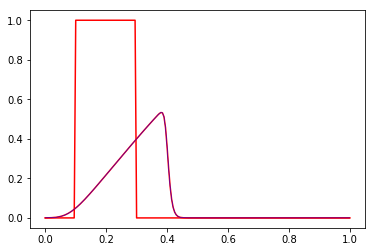

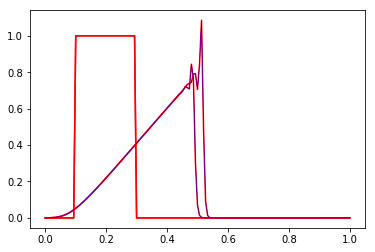

In [225]:
X = SolveBurger(201,15,0.5,0.001,"picard",1)
Plotting(X,201)
print( "picards linearisation is inaccurate for large time steps" )
print( "implicit allows for big timesteps, but this will make picards approximation inaccurate")
## the scheme for theta=1 converges even for few large timesteps.
## however the equation solved is inaccurate, it isnt the correct eqaution.

plt.figure(2)
X = SolveBurger(151,501,0.5,0.001,"picard",0.5) 
Plotting(X,151)
plt.figure(2)
X = SolveBurger(151,201,0.5,0.001,"picard",1) 
Plotting(X,151)

here we get that newton is picards is ftcs for theta = 0


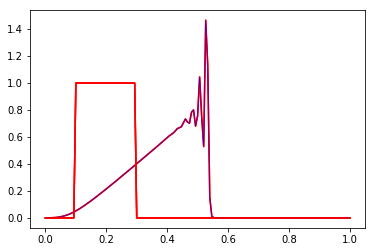

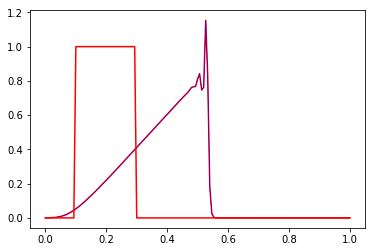

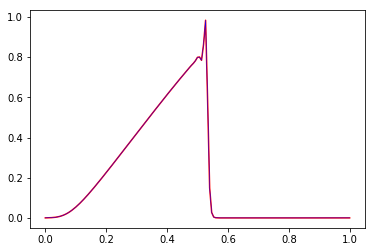

In [212]:

#consistency of code:
plt.figure(0)
X = SolveBurger(151,151,0.5,0.001,"newton",0)
Plotting(X,151)
X = SolveBurger(151,151,0.5,0.001,"picard",0) 
Plotting(X,151)
print("here we get that newton is picards is ftcs for theta = 0")

X = SolveBurger(151,151,0.5,0.001,"newton",0.5)
plt.figure(1)
Plotting(X,151)
X = SolveBurger(151,151,0.5,0.001,"newton",1)
plt.figure(2)
Plotting(X,151)

##look even newton has theta stability conditions?
## there is a timestep restriction independent of the timestep condition.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.971638e-25
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.021895e-44
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.853614e-60
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.527322e-80
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/sit

ValueError: array must not contain infs or NaNs

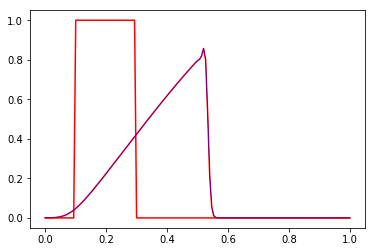

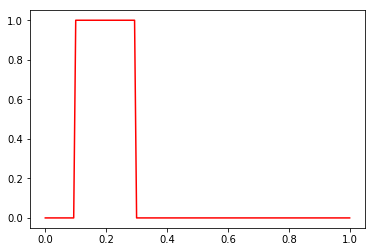

In [213]:
X = SolveBurger(151,101,0.5,0.001,"conservative_newton",1)
Plotting(X,151)
plt.figure(0)
X = SolveBurger(151,81,0.5,0.001,"conservative_newton",1)
Plotting(X,151)
print("Here is a noteworthy case, the conservative form wont converge. \
why is the timestepping condition stricter than the non conservative form")


consistency of code for theta = 0
it appears implicitness adds diffusivity as before, but not 


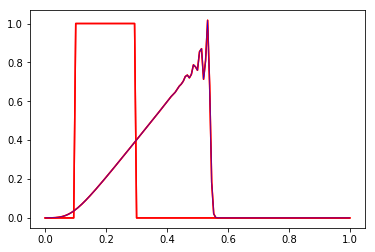

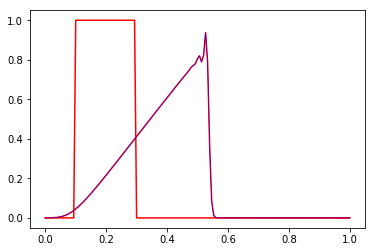

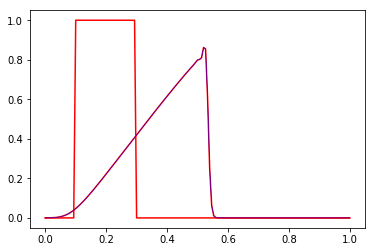

In [214]:
plt.figure(0)
X = SolveBurger(151,151,0.5,0.001,"conservative_newton",0) 
Plotting(X,151)
X = SolveBurger(151,151,0.5,0.001,"conservative_ftcs",0) 
Plotting(X,151)
print("consistency of code for theta = 0")
plt.figure(1)
X = SolveBurger(151,151,0.5,0.001,"conservative_newton",0.5) 
Plotting(X,151)
plt.figure(2)
X = SolveBurger(151,151,0.5,0.001,"conservative_newton",1)
Plotting(X,151)
print("it appears implicitness adds diffusivity as before, but not ")


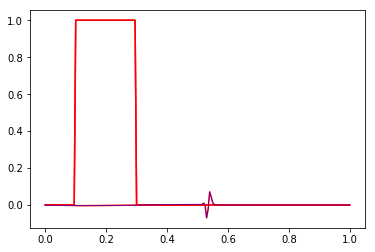

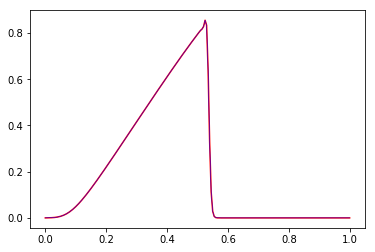

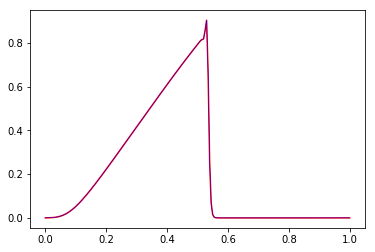

In [215]:
X = SolveBurger(201,201,0.5,0.001,"conservative_newton",1)
Y = SolveBurger(201,201,0.5,0.001,"newton",1)
C = X-Y
plt.figure(1)
Plotting(C,201)
plt.figure(2)
Plotting(X,201)
plt.figure(3)
Plotting(Y,201)

In [ ]:
#•Stability analysis for theta = 0 cases remembering whether vonn neuman annalisis works

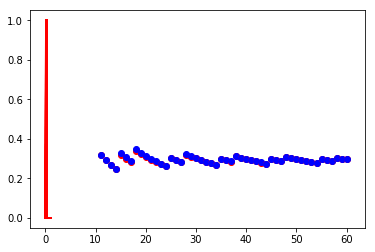

In [216]:

for w in range(50):
 
    nx = 1*w+11
    nt = 601
    AA = SolveBurger(nx,nt,0.5,0.01,"conservative_ftcs",0)
    yy = np.linalg.norm(AA,2)/nx**0.5
    plt.scatter(nx,yy,color='red')
    BB = SolveBurger(nx,nt,0.5,0.01,"picard",0)
    yy = np.linalg.norm(BB,2)/nx**0.5
    plt.scatter(nx,yy,color='blue')
 

ValueError: x and y must have same first dimension, but have shapes (11,) and (1,)

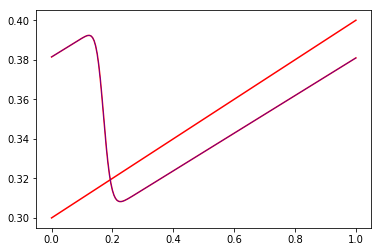

In [226]:
Y = SolveBurger(201,201,0.5,0.001,"newton",0,"analytic")
Plotting(Y,201)
exact = (1)/(1*0.5+1)
plt.plot(x,exact)


In [242]:
class Customer(object):
    """A customer of ABC Bank with a checking account. Customers have the
    following properties:

    Attributes:
        name: A string representing the customer's name.
        balance: A float tracking the current balance of the customer's account.
    """

    def __init__(self, nx ,nt ,Tfinal ,mu, method, theta, initial_condition):
        
        self.nx = nx
        self.nt = nt
        self.Tfinal 
        self.mu = mu
        self.method = method
        self.theta = theta
        self.initial_condition = initial_condition

        ##derived 
        self.x = np.linspace(0,1,nx)
        self.dx = (1-0)/(nx-1) ##
        self.t = np.linspace(0,Tfinal,nt)
        self.dt = (Tfinal-0)/(nt-1)
        self.c = 1*(dt/dx)
        self.d = mu*(dt*1/(dx**2))
    
    ##**Creating the structure**## 
        self.X = np.zeros( [nx] )##**Each row contains a timestep**##
    
    def InitialCondition(self, initial_condition="jump"):
        """Set the customer's starting balance."""
        self.initial_condition = initial_condition


    def withdraw(self, amount):
        """Return the balance remaining after withdrawing *amount*
        dollars."""
        if amount > self.balance:
            raise RuntimeError('Amount greater than available balance.')
        self.balance -= amount
        return self.balance

    def deposit(self, amount):
        """Return the balance remaining after depositing *amount*
        dollars."""
        self.balance += amount
        return self.balance
    

In [248]:
c=Customer('henry')

In [251]:
c.withdraw(5)

0